In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
GPS    = np.genfromtxt('rates.csv', delimiter=',', names=True, case_sensitive=True) 
faults = np.genfromtxt('faults.csv', delimiter=',', names=True, case_sensitive=True) 
coasts = np.genfromtxt('coasts.csv', delimiter=',', names=True, case_sensitive=True)

nd     = np.size(GPS) # number of data points

the original "map" locations have values like 4e6 meters - this just makes
the plots a little cleaner.  Doesn't affect any of the math at all.

In [9]:
GPS['x']=GPS['x']-GPS['x'].mean()
GPS['y']=GPS['y']-GPS['y'].mean()

GPS['UE']=GPS['UE']/1000 #%convert to meters/yr, since our units of distance are in meters
GPS['UN']=GPS['UN']/1000


It can be helpful to add a "scale" arrow of known size - so here I
"augment" the lon, lat and displacement rate vectors by to add in a new
value sitting somewhere offshore where I will also place a text label.


In [10]:
aug_lon = np.append(GPS['lon'],-120)
aug_lat = np.append(GPS['lat'],32.5)
aug_UE  = np.append(GPS['UE'],0.05)
aug_UN  = np.append(GPS['UN'],0)

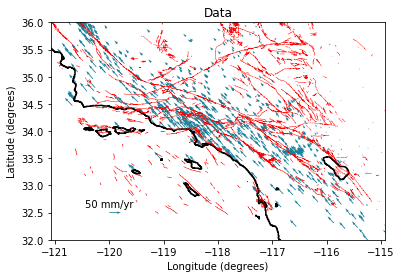

In [11]:
fig=plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(coasts['lon'],coasts['lat'],'k')
ax.plot(faults['lon'],faults['lat'],'r',linewidth=0.5)

#add displacement rate vectors, as well as scale arrow 
ax.quiver(aug_lon,aug_lat, aug_UE,aug_UN,color=((0.1,0.5,0.6)))
ax.text(-120,32.6,'50 mm/yr',horizontalalignment='center')

plt.axis('equal')
plt.xlim([-121, -115])
plt.ylim([32, 36])
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.title('Data')
plt.show()

Now we invert for the big matrix L.  The positions we use here have to
be in meters (GPS_x and GPS_y), not in latitude/longitude.  But it
doesn't matter that we removed that average value.

remember this discussion from class?
G=[ T1 T2 U11 U12 U21 U22]

We are first doing this for all the data at once. (next week look at spatial variation)
First, predefine vectors of ones and  of zeros, since we use them a bunch.

In [12]:
z    = np.zeros(nd)
o    = np.ones(nd)

The first "nd" rows are the related to the eastward components of
displacement, the next nd rows are related to the northward component of
displacement.  You can see that in our data, too.  Note which "chunks" of
G are zeroed out.


In [14]:
G1    = np.column_stack((o,z,GPS['x'],GPS['y'],z,z))  #first set, UE 
G2    = np.column_stack((z,o,z,z,GPS['x'],GPS['y'])) #2nd set, UN
G     = np.concatenate((G1,G2),axis=0)

In [21]:
Gt   = np.transpose(G)
Gg   = np.linalg.inv(Gt.dot(G)).dot(Gt)

data = np.hstack((GPS['UE'],GPS['UN']))

model   = Gg.dot(data)     #inversion -> model
synth   = G.dot(model)          #model -> prediction/synthetic data

sx      = synth[0:nd]      #first nd values are the eastward component
sy      = synth[nd:]     #next nd values are the northward component
np.shape(sx)
np.shape(sy)

(827,)

In [22]:
aug_UE  = np.append(sx,0.05)
aug_UN  = np.append(sy,0)

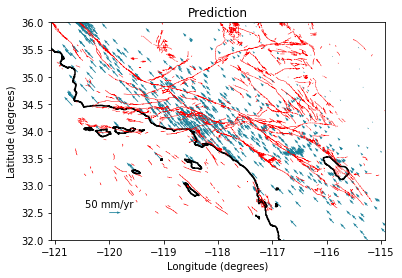

In [23]:
fig=plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(coasts['lon'],coasts['lat'],'k')
ax.plot(faults['lon'],faults['lat'],'r',linewidth=0.5)

#add displacement rate vectors, as well as scale arrow 
ax.quiver(aug_lon,aug_lat, aug_UE,aug_UN,color=((0.1,0.5,0.6)))
ax.text(-120,32.6,'50 mm/yr',horizontalalignment='center')

plt.axis('equal')
plt.xlim([-121, -115])
plt.ylim([32, 36])
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.title('Prediction')
plt.show()

In [24]:
aug_UE  = np.append(GPS['UE']-sx,0.01)
aug_UN  = np.append(GPS['UN']-sy,0)

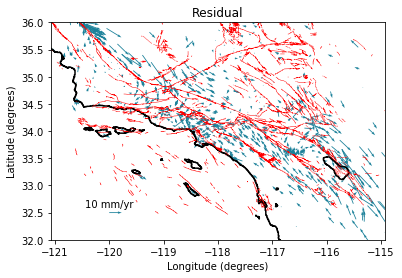

In [25]:
fig=plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(coasts['lon'],coasts['lat'],'k')
ax.plot(faults['lon'],faults['lat'],'r',linewidth=0.5)

#add displacement rate vectors, as well as scale arrow 
ax.quiver(aug_lon,aug_lat, aug_UE,aug_UN,color=((0.1,0.5,0.6)))
ax.text(-120,32.6,'10 mm/yr',horizontalalignment='center')

plt.axis('equal')
plt.xlim([-121, -115])
plt.ylim([32, 36])
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.title('Residual')
plt.show()

# L components

Now lets divide up the individual parts of the model in symmetric and antisymmetric and plot them separately

In [40]:
T = model[0:2] #translation

L = model[2:].reshape(2,2)
W = (L-np.transpose(L))/2
E = (L+np.transpose(L))/2

make prediction (sometimes referred to as "synthetic" data) of JUST the different components

In [42]:
GPSXY=np.transpose(np.column_stack((GPS['x'],GPS['y']))) #this gives us a 2xnp matrix of x and y values, which we need for the matrix multiplication below.

synthL = L.dot(GPSXY);
synthE = E.dot(GPSXY);
synthW = W.dot(GPSXY);
print(np.shape(synthL))

(2, 827)


below  I'm plotting in the projected coordinates, GPS_x and GPS_y, instead
of lat/lon.  Could do either way. A benefit of units in meters is that
they are the same size in both directions, whereas a unit of latitude is
not usually the same distance as a unit of longitude.

Text(0.5, 1.0, 'All components')

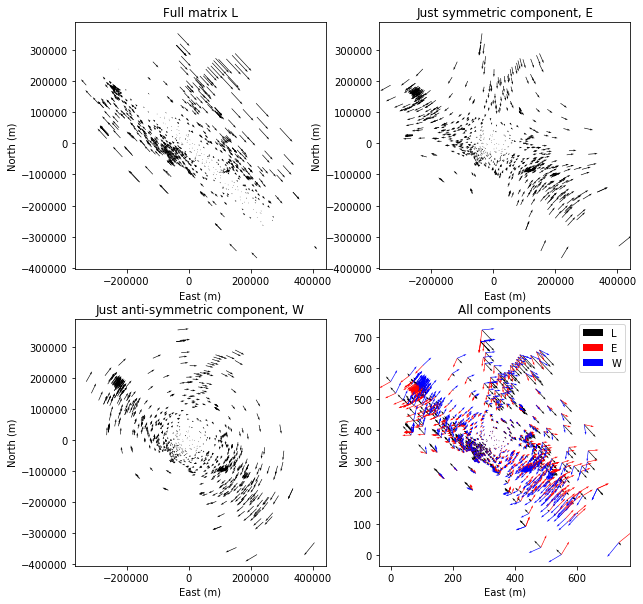

In [57]:
fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(2, 2, 1)    
ax.quiver(GPS['x'],GPS['y'],synthL[0,],synthL[1,]) # have to take the transpose here, since GPS_x is np x 1 and the synthetics are 1 x np
plt.axis('image')
plt.xlabel('East (m)')
plt.ylabel('North (m)')
plt.title('Full matrix L')

ax = fig.add_subplot(2, 2, 2)    
ax.quiver(GPS['x'],GPS['y'],synthE[0,],synthE[1,]) # have to take the transpose here, since GPS_x is np x 1 and the synthetics are 1 x np
plt.axis('image')
plt.xlabel('East (m)')
plt.ylabel('North (m)')
plt.title('Just symmetric component, E')

ax = fig.add_subplot(2, 2, 3)    
ax.quiver(GPS['x'],GPS['y'],synthW[0,],synthW[1,]) # have to take the transpose here, since GPS_x is np x 1 and the synthetics are 1 x np
plt.axis('image')
plt.xlabel('East (m)')
plt.ylabel('North (m)')
plt.title('Just anti-symmetric component, W')

ax = fig.add_subplot(2,2,4)
ax.quiver((GPS['x']-min(GPS['x']))/1e3,(GPS['y']-min(GPS['y']))/1e3,synthL[0,],synthL[1,],scale=0.5) 
ax.quiver((GPS['x']-min(GPS['x']))/1e3,(GPS['y']-min(GPS['y']))/1e3,synthE[0,],synthE[1,],scale=0.5,color='r') 
ax.quiver((GPS['x']-min(GPS['x']))/1e3,(GPS['y']-min(GPS['y']))/1e3,synthW[0,],synthW[1,],scale=0.5,color='b') 
ax.legend(['L','E','W'])
plt.axis('image')
plt.xlabel('East (m)')
plt.ylabel('North (m)')
plt.title('All components')





now the eigenvector stuff

In [64]:
e, v = np.linalg.eig(E)   #matrix of eigenvectors (v) and eigenvalues (diag e)

plot principle components with arrows

(-200, 200)

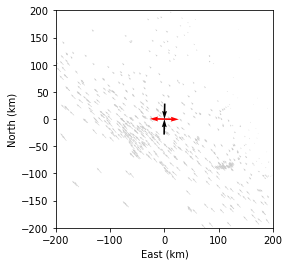

In [82]:
fig=plt.figure()
ax = fig.add_subplot(1, 1, 1)   
#ax.quiver(GPS['x'],GPS['y'],synthW[0,],synthW[1,]) # have to take the transpose here, since GPS_x is np x 1 and the synthetics are 1 x np

ax.quiver(GPS['x']/1e3,GPS['y']/1e3,GPS['UE'],GPS['UN'],color=((0.8,0.8,0.8)))
plt.axis('image')
plt.xlabel('East (km)')
plt.ylabel('North (km)')

#plot arrows pointing in or out, depending on the sign of that eigenvalue
#loop over the two eigenvectors
for i in [0,1]:
    if e[i]>0:
        ax.quiver(0,0,v[0,i]*e[i],v[1,i]*e[i],scale=1e-6,color='r')
        ax.quiver(0,0,-v[0,i]*e[i],-v[1,i]*e[i],scale=1e-6,color='r')
    else:
        ax.quiver(0,0,v[0,i]*e[i],v[1,i]*e[i],scale=1e-6,color='k',pivot='tip')
        ax.quiver(0,0,-v[0,i]*e[i],-v[1,i]*e[i],scale=1e-6,color='k',pivot='tip')

        
plt.xlim([-200, 200])
plt.ylim([-200, 200])